In [16]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import torch
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import pyro
from pyro.infer.autoguide import AutoLaplaceApproximation, AutoIAFNormal, AutoMultivariateNormal, AutoNormalizingFlow, AutoDiagonalNormal, AutoDelta, init_to_mean
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Predictive, MCMC, NUTS
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints

In [3]:
import sys
sys.path.append("../")

In [74]:
from models.likelihoods import log_like_np
from models.nptf_model import NPRegression
from utils.templates import get_NFW2_template
from utils.psf_correction import PSFCorrection
from utils import create_mask as cm
from models.psf import KingPSF

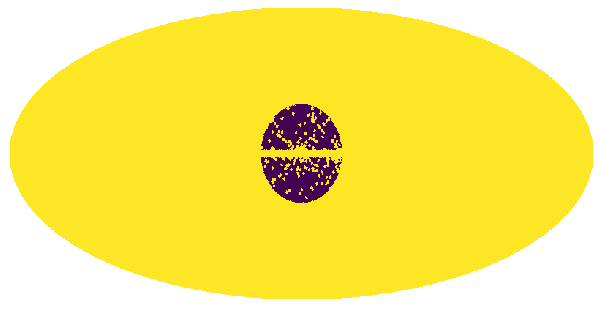

In [11]:
nside = 128
ps_mask = hp.ud_grade(np.load("../data/mask_3fgl_0p8deg.npy") > 0, nside_out=nside)

mask = cm.make_mask_total(nside=nside, band_mask = True, band_mask_range = 2,
                          mask_ring = True, inner = 0, outer = 25, 
                          custom_mask=ps_mask)

hp.mollview(mask,title='',cbar=False,min=0,max=1)

In [20]:
# Load templates
temp_gce = get_NFW2_template(gamma=1.2)
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk = np.load("../data/fermi_data/template_dsk.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

temp_mA_pibrem = hp.ud_grade(np.load('../data/modelA/modelA_brempi0.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/modelA/modelA_ics.npy'), nside_out=128, power=-2)

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")
fermi_data = np.load("../data/fermi_data/fermidata_counts.npy")

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask)

In [92]:
# Define parameters that specify the Fermi-LAT PSF at 2 GeV
fcore = 0.748988248179
score = 0.428653790656
gcore = 7.82363229341
stail = 0.715962650769
gtail = 3.61883748683
spe = 0.00456544262478

# Define the full PSF in terms of two King functions
def king_fn(x, sigma, gamma):
    return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

def Fermi_PSF(r):
    return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

# Modify the relevant parameters in pc_inst and then make or load the PSF
pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
pc_inst.psf_samples = 10000
pc_inst.psf_tag = 'Fermi_PSF_2GeV'
pc_inst.make_or_load_psf_corr()

# Extract f_ary and df_rho_div_f_ary as usual
f_ary = pc_inst.f_ary
df_rho_div_f_ary = pc_inst.df_rho_div_f_ary

Loading the psf correction from: /Users/smsharma/PycharmProjects/sbi-fermi/notebooks/psf_dir/Fermi_PSF_2GeV.npy


In [215]:
nside = 128

# Get mask of central pixel for nside=1
hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask=True, band_mask_range=0, mask_ring=True, inner=0, outer=25)

# Get mask corresponding to nside=128
mask_sim = hp.ud_grade(hp_mask_nside1, nside)

npix = hp.nside2npix(nside)
pixarea = hp.nside2pixarea(nside, degrees=False)
pixarea_deg = hp.nside2pixarea(nside, degrees=True)

In [428]:
npr = NPRegression(poiss_temps=[temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics, temp_gce],
            poiss_priors=[dist.Uniform(torch.tensor(0.02), torch.tensor(1.5)),
                          dist.Uniform(torch.tensor(0.02), torch.tensor(1.5)),
                          dist.Uniform(torch.tensor(0.02), torch.tensor(1.5)),
                          dist.Normal(torch.tensor(6.), torch.tensor(12.)),
                          dist.Uniform(torch.tensor(2.), torch.tensor(6.)),
                          dist.Uniform(torch.tensor(0.001), torch.tensor(1.))],
            poiss_log_priors=torch.tensor([0., 0., 0., 0.,0., 0.]),
            ps_temps=[temp_gce, temp_dsk],
            ps_priors=2 * [[dist.Uniform(torch.tensor(0.001), torch.tensor(1.)), 
                        dist.Uniform(torch.tensor(11.0), torch.tensor(20.0)), 
                        dist.Uniform(torch.tensor(0.1), torch.tensor(1.99)), 
                        dist.Uniform(torch.tensor(-10.0), torch.tensor(1.99)), 
                        dist.Uniform(torch.tensor(5.), torch.tensor(50.)), 
                        dist.Uniform(torch.tensor(0.1), torch.tensor(4.99))]],
            ps_log_priors=torch.tensor(2 * [[0., 0., 0., 0., 0., 0.]]),
            data = torch.tensor(fermi_data, dtype=torch.float64),
            labels_poiss=["iso", "bub", "psc", "brem", "pi0", "gce"],
            labels_ps=["gce", "dsk"],
            mask=mask,
            mask_sim=mask_sim,
            f_ary=f_ary,
            df_rho_div_f_ary=df_rho_div_f_ary,
            subsample_size=2048)

../models/nptf_model.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data)


In [436]:
# guide = AutoMultivariateNormal(npr.model, init_loc_fn=init_to_mean)
guide = AutoIAFNormal(npr.model)

In [437]:
elbo = TraceGraph_ELBO()
optimizer = optim.AdamW({"lr": 1e-4})

In [439]:
pyro.clear_param_store()

num_iterations = 1000

svi = SVI(npr.model,
          guide,
          optimizer,
          loss=elbo)

for j in range(num_iterations):
    loss = svi.step()    
    if j % 1 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(fermi_data)))

In [442]:
# pyro.clear_param_store()

# num_samples = 100

# predictive = Predictive(npr.model, guide=guide, num_samples=num_samples)
# svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
#                for k, v in (predictive().items())
#                if k != "obs"}


In [444]:
# nuts_kernel = NUTS(npr.model, adapt_mass_matrix=False, adapt_step_size=False)

# mcmc = MCMC(nuts_kernel, num_samples=20, warmup_steps=10)
# mcmc.run()

# hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

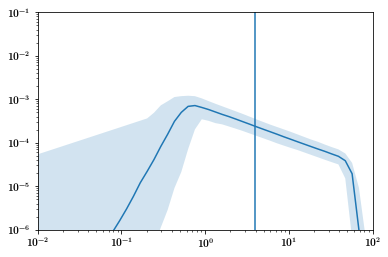

In [136]:
# from models.scd import dnds
samplez = np.transpose([svi_samples[key] for key in svi_samples.keys()])
samplez[:,6] = 10 ** samplez[:,6]
samplez[:,11] = 10 ** samplez[:,11]
s_ary = np.logspace(-2, 2)
dnds_ary = [dnds(torch.tensor(s_ary), torch.tensor(s)).detach().numpy() for s in samplez[:,6:12]]
plt.plot(s_ary, np.median(dnds_ary, axis=0))
plt.fill_between(s_ary, np.percentile(dnds_ary, [5.], axis=0)[0], np.percentile(dnds_ary, [95.], axis=0)[0], alpha=0.2)
# theta_sim = torch.tensor([4000., 20., 1.8, -20., 30., 1.])
# plt.plot(s_ary, dnds(torch.tensor(s_ary), theta_sim).detach().numpy() / len(data))
plt.xlim(1e-2, 1e2)
plt.ylim(1e-6, 1e-1)
plt.axvline(np.sqrt(np.mean(fermi_data[~mask])))

plt.xscale("log")
plt.yscale("log")
